In [1]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# 1. Re-instantiate the skin cancer model with help of the model architecture and the model weights file.

In [2]:
from tensorflow.keras.models import model_from_json

with open('./model_not_frozen1970annototation_type.border.json', 'r') as json_file:
    loaded_model_json = json_file.read()

model = model_from_json(loaded_model_json)
model.load_weights('./model_not_frozen1970annototation_type.border.h5')

In [3]:
model.summary()

Model: &quot;model_1&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 384, 384, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 384, 384, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 192, 192, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________

# 2. How is the last convolutional layer named?

In [4]:
conv_layers = [layer for layer in model.layers if "conv" in layer.name]
layer = conv_layers[-1]
print(layer.name)

block5_conv3


# 3. Make a prediction using this image.

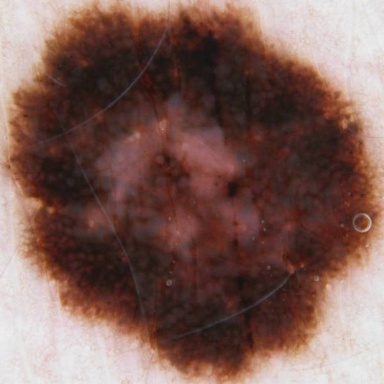

In [5]:
from tensorflow.keras.preprocessing import image
from IPython.display import Image
import matplotlib.cm as cm
import matplotlib.pyplot as plt

img = image.load_img('./ISIC_0000029.jpg',  target_size=(384, 384))
display(img)

In [6]:
import numpy as np

img_array = image.img_to_array(img) / 255
batch_img_array = np.expand_dims(img_array, axis=0)
print(batch_img_array.shape)

(1, 384, 384, 3)


In [7]:
y_pred = model.predict(batch_img_array)

In [8]:
y_pred

[array([[0.71730685]], dtype=float32), array([[0.45079383]], dtype=float32)]

# 4. Get the class activation heatmap using the last convolutional layer name

In [9]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

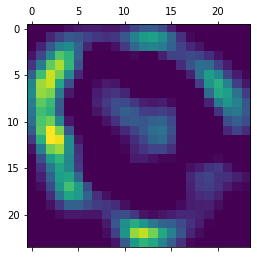

In [10]:
# get the last layers which make it a classifier.
# since this is a model which has two outputs, we can just remove out_asym  
classifier_layer_names = [lyr.name for lyr in model.layers][-5:-1]

heatmap = make_gradcam_heatmap(batch_img_array, model, layer.name, classifier_layer_names)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# 5. Next, plot the original image, the heatmap and the two as an overlay image.

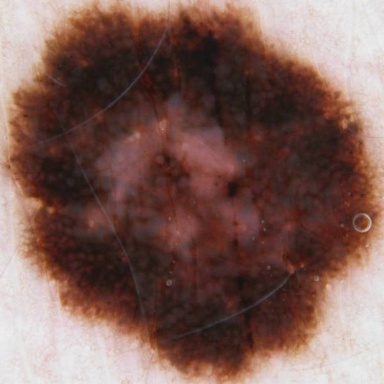

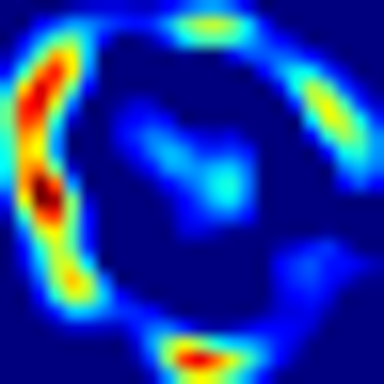

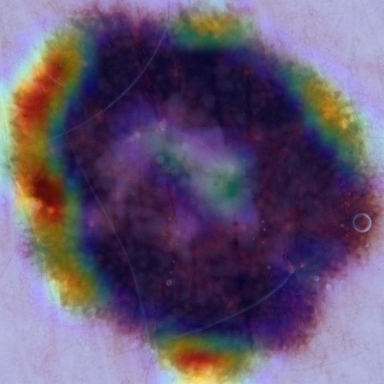

In [11]:
# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
jet_heatmap = image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "skin_lesion_border.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(img)
display(image.array_to_img(jet_heatmap))
display(superimposed_img)

# 6. What can you conclude from the overlay?
It has succesfully activated on the skin lesion its borders. Which was also the task of this model.